<a href="https://colab.research.google.com/github/yontodd/durable_goods_orders_v1/blob/main/Durable_Goods_Orders_(comment_version)_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Add prior month's unrevised data and current month estimates:

In [181]:
# Add prior month's unrevised data and current month estimates:

month = "2023-01-01"
rpt_list = ["Headline durable goods orders", "Durable Goods (ex. transportation)", "Core capital goods orders (ex. defense and aircraft)", "Core capital goods shipments (which feeds into GDP)"]
prior_unrevised = [5.6, -0.2, -0.1, -0.4]
estimate = [-3.5, -0.1, 0.0, 0.2]

# Dataframe code

In [182]:
import requests
import pandas as pd
import numpy as np
import datetime
import dateutil
import calendar

from matplotlib import pyplot as plt

In [183]:
time = pd.to_datetime(month, format ='%Y-%m')
m = [month, month, month, month]
df2 = pd.DataFrame(zip(m, rpt_list, prior_unrevised, estimate), columns=["time", "report", "prior_unrevised", "estimate"])

# Step 2: Check prior/consensus estimates are correct

In [184]:
df2

,time,report,prior_unrevised,estimate
0,2023-01-01,Headline durable goods orders,5.6,-3.5
1,2023-01-01,Durable Goods (ex. transportation),-0.2,-0.1
2,2023-01-01,Core capital goods orders (ex. defense and air...,-0.1,0.0
3,2023-01-01,Core capital goods shipments (which feeds into...,-0.4,0.2


# Durable Goods Orders indicators code

In [185]:
base_url = "https://api.census.gov/data/timeseries/eits/advm3?get=data_type_code,time_slot_id,seasonally_adj,category_code,cell_value,error_data&for=us:*&time=from+{}".format("2020-03")
response = requests.get(base_url)
data = response.json()
df = pd.DataFrame(data[1:], columns = data[0])

In [186]:
df["time"] = pd.to_datetime(df["time"], format = '%Y-%m')
df["cell_value"] = [float(str(i).replace(",","")) for i in df["cell_value"]]
df["cell_value"] = df["cell_value"].map(lambda x: float(x))
df["month"] = df["time"].map(lambda x: x.strftime("%b"))

In [187]:
rpt_list = ["Headline durable goods orders", "Core Orders (Non-defense, ex-Aircraft)", "Durable Goods (ex. transportation)", "Core capital goods orders (ex. defense and aircraft)", "Core capital goods shipments (which feeds into GDP)"]
data_type_code = ["MPCNO", "MPCNO","MPCNO", "MPCNO", "MPCVS"]
category_code = ["MDM", "NXA", "DXT", "NXA", "NXA"]
cols = ["report", "data_type_code","category_code"]
zip_list = pd.DataFrame(zip(rpt_list, data_type_code, category_code))
zip_list.columns = cols

In [188]:
type_variables = ["MPCNO","MPCVS"]
cat_variables = ["MDM", "NXA", "DXT","NXA","NXA"]
seas_code = "yes"
dg_data = df[(df.data_type_code.isin(type_variables)) &
   (df.category_code.isin(cat_variables)) &
   (df["seasonally_adj"] == seas_code)]

In [189]:
durable_goods_orders = pd.merge(zip_list, dg_data, how = 'left', left_on = ["data_type_code","category_code"], right_on = ["data_type_code","category_code"])
durable_goods_orders = durable_goods_orders.sort_values(by = "time", ascending=False)
durable_goods_orders = durable_goods_orders.reset_index()
durable_goods_orders = durable_goods_orders.drop(columns= "index")

In [190]:
headline = durable_goods_orders[durable_goods_orders["report"] == "Headline durable goods orders"].reset_index()
core_ex_transport = durable_goods_orders[durable_goods_orders["report"] == "Durable Goods (ex. transportation)"].reset_index()
core_ex_defense_aircraft = durable_goods_orders[durable_goods_orders["report"] == "Core Orders (Non-defense, ex-Aircraft)"].reset_index()
core_capital_goods_deliveries = durable_goods_orders[(durable_goods_orders["report"] == "Core capital goods shipments (which feeds into GDP)")].reset_index()

In [191]:
# Formatting for negative/positive numbers
import string
class NegativeParenFormatter(string.Formatter):
    def format_field(self, value, format_spec):
        try:
            if value<0:
                return "(" +  string.Formatter.format_field(self, -value, format_spec) + ")"
            elif value==0:
                return string.Formatter.format_field(self, -value, format_spec)
            else:
                return "+" +  string.Formatter.format_field(self, value, format_spec)
        except:
            return string.Formatter.format_field(self, value, format_spec)

f = NegativeParenFormatter()

# Print statement code

In [192]:
headline_mnth = headline["month"][0]
headline_actual = headline["cell_value"][0]/100
headline_estimate = df2[df2["report"] == "Headline durable goods orders"]["estimate"].values[0]/100
core_orders_actual = core_ex_defense_aircraft["cell_value"][0]/100

orders_ex_transport_actual = core_ex_transport["cell_value"][0]/100
orders_ex_transport_estimate = df2[df2["report"] == "Durable Goods (ex. transportation)"]["estimate"].values[0]/100

previous_mnth = headline["month"][1]
previous_headline_orders = headline["cell_value"][1]/100
headline_orders_unrevised = df2[df2["report"] == "Headline durable goods orders"]["prior_unrevised"].values[0]/100

previous_core_ex_defense_aircraft = core_ex_defense_aircraft["cell_value"][1]/100
core_ex_defense_aircraft_unrevised = df2[df2["report"] == "Core capital goods orders (ex. defense and aircraft)"]["prior_unrevised"].values[0]/100

previous_orders_ex_transport = core_ex_transport["cell_value"][1]/100
orders_ex_transport_previous_revision = df2[df2["report"] == "Durable Goods (ex. transportation)"]["prior_unrevised"].values[0]/100

def print_statements():
  print(f.format("{} US Durable Orders {:.1%} vs StreetAccount Consensus {:.1%}; {} Core Orders (Non-defense, ex-Aircraft) {:.1%}",
               headline_mnth, headline_actual, headline_estimate, headline_mnth, core_orders_actual))
  print()
  print(f.format("{} ex-transport {:.1%} vs. SA {:.1%}",
               headline_mnth, orders_ex_transport_actual,orders_ex_transport_estimate))
  print(f.format("{} Orders revised to {:.1%} from {:.1%}",previous_mnth, previous_headline_orders, headline_orders_unrevised))
  print(f.format("{} Core Orders (Non-defense, ex-Aircraft) revised to {:.1%} from {:.1%}", previous_mnth, previous_core_ex_defense_aircraft, core_ex_defense_aircraft_unrevised))
  print(f.format("{} ex-transport previously revised to {:.1%} from revised {:.1%}", previous_mnth, previous_orders_ex_transport, orders_ex_transport_previous_revision))

# Step 3: Copy Print Statement

In [193]:
print_statements()

Jan US Durable Orders (4.5%) vs StreetAccount Consensus (3.5%); Jan Core Orders (Non-defense, ex-Aircraft) +0.8%

Jan ex-transport +0.7% vs. SA (0.1%)
Dec Orders revised to +5.1% from +5.6%
Dec Core Orders (Non-defense, ex-Aircraft) revised to (0.3%) from (0.1%)
Dec ex-transport previously revised to (0.4%) from revised (0.2%)


# Step 4: Accessory graphs/tables

<AxesSubplot:title={'center':'Core capital goods deliveries (which feed into GDP)'}, xlabel='time', ylabel='%'>

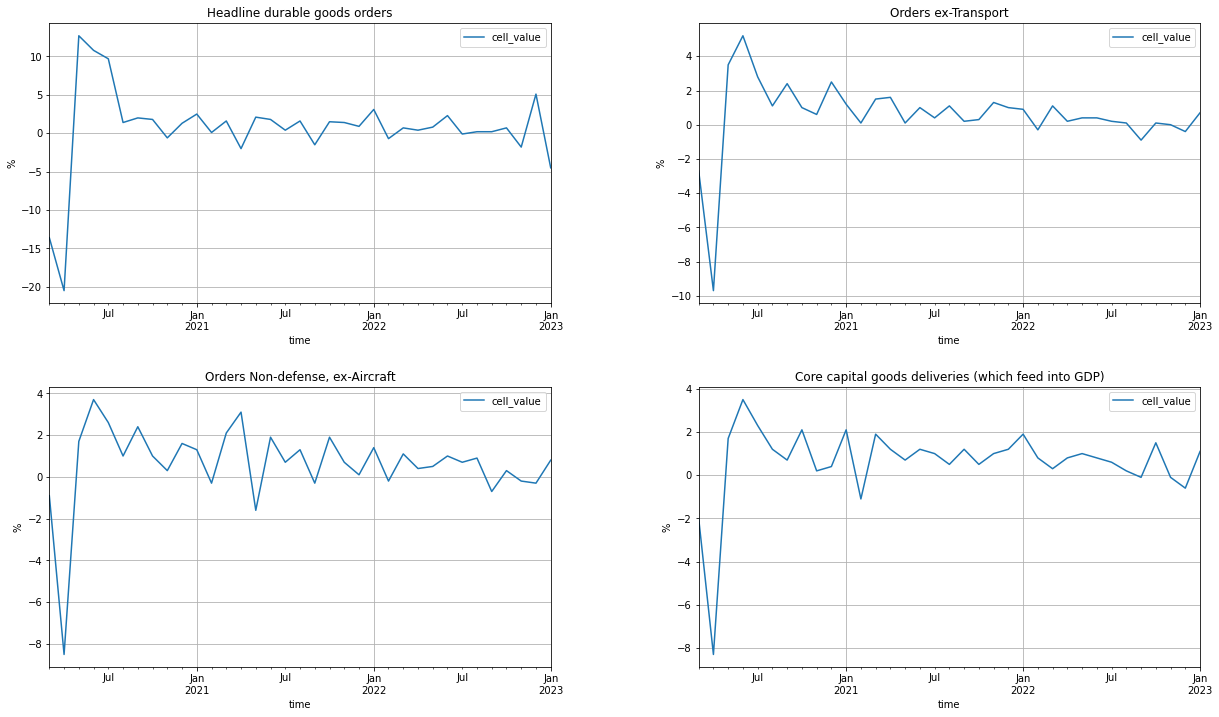

In [194]:
%matplotlib inline
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.tight_layout()
fig.set_size_inches(18.5, 10.5, forward=True)

headline.plot(y="cell_value",x="time", title="Headline durable goods orders", ylabel="%", grid=True, ax=axes[0,0])
core_ex_transport.plot(y="cell_value",x="time", title="Orders ex-Transport", ylabel="%", grid=True, ax=axes[0,1])
core_ex_defense_aircraft.plot(y="cell_value",x="time", title="Orders Non-defense, ex-Aircraft", ylabel="%", grid=True, ax=axes[1,0])
core_capital_goods_deliveries.plot(y="cell_value",x="time", title="Core capital goods deliveries (which feed into GDP)", ylabel="%", grid=True, ax=axes[1,1])

# Tables

In [195]:
table_months = 12

In [196]:
headline.head(table_months)

,index,report,data_type_code,category_code,time_slot_id,seasonally_adj,cell_value,error_data,time,us,month
0,0,Headline durable goods orders,MPCNO,MDM,0,yes,-4.5,no,2023-01-01,1,Jan
1,5,Headline durable goods orders,MPCNO,MDM,0,yes,5.1,no,2022-12-01,1,Dec
2,10,Headline durable goods orders,MPCNO,MDM,0,yes,-1.8,no,2022-11-01,1,Nov
3,19,Headline durable goods orders,MPCNO,MDM,0,yes,0.7,no,2022-10-01,1,Oct
4,24,Headline durable goods orders,MPCNO,MDM,0,yes,0.2,no,2022-09-01,1,Sep
5,26,Headline durable goods orders,MPCNO,MDM,0,yes,0.2,no,2022-08-01,1,Aug
6,32,Headline durable goods orders,MPCNO,MDM,0,yes,-0.1,no,2022-07-01,1,Jul
7,36,Headline durable goods orders,MPCNO,MDM,0,yes,2.3,no,2022-06-01,1,Jun
8,42,Headline durable goods orders,MPCNO,MDM,0,yes,0.8,no,2022-05-01,1,May
9,48,Headline durable goods orders,MPCNO,MDM,0,yes,0.4,no,2022-04-01,1,Apr


In [197]:
core_ex_transport.head(table_months)

,index,report,data_type_code,category_code,time_slot_id,seasonally_adj,cell_value,error_data,time,us,month
0,2,Durable Goods (ex. transportation),MPCNO,DXT,0,yes,0.7,no,2023-01-01,1,Jan
1,6,Durable Goods (ex. transportation),MPCNO,DXT,0,yes,-0.4,no,2022-12-01,1,Dec
2,11,Durable Goods (ex. transportation),MPCNO,DXT,0,yes,0.0,no,2022-11-01,1,Nov
3,15,Durable Goods (ex. transportation),MPCNO,DXT,0,yes,0.1,no,2022-10-01,1,Oct
4,20,Durable Goods (ex. transportation),MPCNO,DXT,0,yes,-0.9,no,2022-09-01,1,Sep
5,25,Durable Goods (ex. transportation),MPCNO,DXT,0,yes,0.1,no,2022-08-01,1,Aug
6,33,Durable Goods (ex. transportation),MPCNO,DXT,0,yes,0.2,no,2022-07-01,1,Jul
7,35,Durable Goods (ex. transportation),MPCNO,DXT,0,yes,0.4,no,2022-06-01,1,Jun
8,41,Durable Goods (ex. transportation),MPCNO,DXT,0,yes,0.4,no,2022-05-01,1,May
9,47,Durable Goods (ex. transportation),MPCNO,DXT,0,yes,0.2,no,2022-04-01,1,Apr


In [198]:
core_ex_defense_aircraft.head(table_months)

,index,report,data_type_code,category_code,time_slot_id,seasonally_adj,cell_value,error_data,time,us,month
0,4,"Core Orders (Non-defense, ex-Aircraft)",MPCNO,NXA,0,yes,0.8,no,2023-01-01,1,Jan
1,9,"Core Orders (Non-defense, ex-Aircraft)",MPCNO,NXA,0,yes,-0.3,no,2022-12-01,1,Dec
2,12,"Core Orders (Non-defense, ex-Aircraft)",MPCNO,NXA,0,yes,-0.2,no,2022-11-01,1,Nov
3,18,"Core Orders (Non-defense, ex-Aircraft)",MPCNO,NXA,0,yes,0.3,no,2022-10-01,1,Oct
4,22,"Core Orders (Non-defense, ex-Aircraft)",MPCNO,NXA,0,yes,-0.7,no,2022-09-01,1,Sep
5,27,"Core Orders (Non-defense, ex-Aircraft)",MPCNO,NXA,0,yes,0.9,no,2022-08-01,1,Aug
6,34,"Core Orders (Non-defense, ex-Aircraft)",MPCNO,NXA,0,yes,0.7,no,2022-07-01,1,Jul
7,39,"Core Orders (Non-defense, ex-Aircraft)",MPCNO,NXA,0,yes,1.0,no,2022-06-01,1,Jun
8,40,"Core Orders (Non-defense, ex-Aircraft)",MPCNO,NXA,0,yes,0.5,no,2022-05-01,1,May
9,45,"Core Orders (Non-defense, ex-Aircraft)",MPCNO,NXA,0,yes,0.4,no,2022-04-01,1,Apr


In [199]:
core_capital_goods_deliveries.head(table_months)

,index,report,data_type_code,category_code,time_slot_id,seasonally_adj,cell_value,error_data,time,us,month
0,3,Core capital goods shipments (which feeds into...,MPCVS,NXA,0,yes,1.1,no,2023-01-01,1,Jan
1,8,Core capital goods shipments (which feeds into...,MPCVS,NXA,0,yes,-0.6,no,2022-12-01,1,Dec
2,14,Core capital goods shipments (which feeds into...,MPCVS,NXA,0,yes,-0.1,no,2022-11-01,1,Nov
3,17,Core capital goods shipments (which feeds into...,MPCVS,NXA,0,yes,1.5,no,2022-10-01,1,Oct
4,23,Core capital goods shipments (which feeds into...,MPCVS,NXA,0,yes,-0.1,no,2022-09-01,1,Sep
5,28,Core capital goods shipments (which feeds into...,MPCVS,NXA,0,yes,0.2,no,2022-08-01,1,Aug
6,30,Core capital goods shipments (which feeds into...,MPCVS,NXA,0,yes,0.6,no,2022-07-01,1,Jul
7,37,Core capital goods shipments (which feeds into...,MPCVS,NXA,0,yes,0.8,no,2022-06-01,1,Jun
8,44,Core capital goods shipments (which feeds into...,MPCVS,NXA,0,yes,1.0,no,2022-05-01,1,May
9,49,Core capital goods shipments (which feeds into...,MPCVS,NXA,0,yes,0.8,no,2022-04-01,1,Apr
